***'Syntax natürlicher Sprachen',*** **Wintersemester 2020/21**

--- 
# Klausur: Syntax natürlicher Sprachen *(06.03.2021)*

- **Bearbeitungszeitraum: 10:15-11:45**
- **Abgabe in Moodle bis 12:05**


---

## Übersicht

- [Hinweise zur Bearbeitung](#Hinweise-zur-Bearbeitung)
- [Laden von Paketen](#Laden-von-Paketen)


1. [Temporale-Ambiguität](#1.-Temporale-Ambiguität)
2. [Syntaktische Ambiguität](#2.-Syntaktische-Ambiguität)
3. [Konstituenten- und Adjunkttests](#3.-Konstituenten--und-Adjunkttests)
4. [CFG Analysen](#4.-CFG-Analysen)
5. [Dependenzanalyse](#5.-Dependenzanalyse)
6. [FCFG-Erweiterung: Kasus, Agreement, Subkategorisierung](#6.-FCFG-Erweiterung:-Kasus,-Agreement,-Subkategorisierung)
7. [Slash-Kategorien, Inversion, Wortstellung](#7.-Slash-Kategorien,-Inversion,-Wortstellung)
8. [Syntaxregeln komplexer Sätze](#8.-Syntaxregeln-komplexer-Sätze)
9. [Parsing-Algorithmen und Rekursionstypen](#9.-Parsing-Algorithmen-und-Rekursionstypen)
10. [Unifikationsparsing](#10.-Unifikationsparsing-und-getypte-Merkmalstrukturen)
11. [Statistisches Parsing](#11.-Statistisches-Parsing)
12. [Datengestützte Syntaxanalyse](#12.-Datengestützte-Syntaxanalyse)
13. [Chunk-Analysen und Komplexität](#13.-Chunk-Analysen-und-Komplexität)



---

## Hinweise zur Bearbeitung

### Falls noch nicht geschehen, benennen Sie bitte zunächst die Datei der Klausur-Angabe nach folgendem Schema um: 

 #### `Nachname_Vorname_Matrikelnummer.ipynb`
 

--- 

## Hinweise zum Ausfüllen der Codezellen

### Wenn gegeben, führen Sie zunächst die mit `#RUN` markierten Codezellen zu Beginn einer Aufgabe aus (dies ist für eine erfolgreiche Bearbeitung der Aufgabe notwendig).

### Verändern Sie nur die `#TO_DO`-Codezellen (nur gemäß der Angabe in der jeweiligen Aufgabe)!

### Führen Sie `#TO_DO`-Codezellen nach Bearbeitung aus, um das Output ihrer Lösung zu generieren (dieses muss als Teil Ihrer Lösung mit abgespeichert werden); bei aufeinander aufbauenden Aufgaben (`a)`, `b)`usw.) ist zudem  notwendig, dass Sie Ihre Lösung aus der vorangehenden Teilaufgabe ausführen, damit diese in der folgenden zur Verfügung steht.

### Angegebene Inhalte (Grammatikregeln usw.) dürfen nicht auskommentiert oder gelöscht werden, außer dies wird explizit anders erwähnt!


### WICHTIG: Setzen Sie den Status des Notebooks ggf. auf `Trusted`, damit alle angegebenen Outputs korrekt angezeigt werden.

---

## Zuordung durch Matrikelnummer
### Bearbeiten Sie, falls explizit darauf hingewiesen wird, nur das Beispiel, das Ihnen gemäß der angegebenen Verteilung anhand der letzten Stelle Ihrer Matrikelnummer zugeordnet wird.


---

## Laden von Paketen

### Führen Sie zu Beginn folgende Codezelle aus.

### Das erfolgreiche Ausführen dieser Codezelle ist Voraussetzung für die Bearbeitung der folgenden Aufgaben.  

In [1]:
import nltk
from nltk.tree import Tree
from nltk import FeatStruct
import itertools


from spacy import displacy

def transform_nr_conll(sent_nr):
    sent_list = []
    for line in list(filter(None, sent_nr.split("\n"))):
        line_list = line.split()
        line_list.pop(0)
        line_list.insert(1,"_")
        sent_list.append(" ".join([i for i in line_list[0:]]))

    return "\n".join([i for i in sent_list[0:]])



from nltk import DependencyGraph
from itertools import chain

def _tree_labeled(self, i):
        node = self.get_by_address(i)
        word = node["word"]
        rel = node["rel"]        
        deps = sorted(chain.from_iterable(node["deps"].values()))

        if deps:
            return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])
        else:
            return word+'('+rel+')'
        
def tree_labeled(self):
        node = self.root

        word = node["word"]
        rel = node["rel"]
        deps = sorted(chain.from_iterable(node["deps"].values()))
        return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])

DependencyGraph._tree_labeled = _tree_labeled
DependencyGraph.tree_labeled = tree_labeled



def displacy_dep_input(sent):
    deps = []
    for dep in sent.split('\n'):
        deps.append(dep.split())

    deps = [x for x in deps if x]

    ex = []
    word_list = []
    arc_list = []

    for index, dep in enumerate(deps):
        word_list.append({"text": dep[0], "tag": ""})
        line = index+1
        head = int(dep[2])
        label = dep[3]
        if head>line:
            start = index
            end = head-1
            direction = "left"
        else:
            start = head-1
            end = index  
            direction = "right"
        if(label.lower() != "root"):
            arc_list.append({"start": start, "end": end, "label": label, "dir": direction})

    ex.append({
        "words": word_list,
        "arcs": arc_list
    })    

    return ex



from nltk.featstruct import Feature, UnificationFailure, FeatStructReader
import itertools
from collections import defaultdict


def check_sanity_constraints(th):
    for type1, type2 in itertools.product(th, th):
        if type1 in th[type2] and type2 in th[type1]:
            if type1 != type2:
                raise ValueError(
                    "The type hierarchy is not antisymmetric! " +
                    "{} subsumes {} and vice versa!".format(
                        type1, type2
                    )
                )


def refl_trans_closure(type_hierarchy):
    # make everything a set
    # and compute reflexive closure
    closure = defaultdict(set)
    for t in type_hierarchy:
        closure[t] = set(type_hierarchy[t])
        closure[t].add(t)

    # compute transitive closure
    still_changes = True
    while still_changes:
        still_changes = False
        for x in closure:
            new_for_x = set()
            for y in closure[x]:
                for z in closure[y]:
                    new_for_x.add(z)
            len_before = len(closure[x])
            closure[x].update(new_for_x)
            still_changes |= len(closure[x]) > len_before

    return closure


class HierarchicalFeature(Feature):
    def __init__(self, name, type_hierarchy, **kwargs):
        super(HierarchicalFeature, self).__init__(name, **kwargs)

        self.hierarchy = refl_trans_closure(type_hierarchy)
        check_sanity_constraints(self.hierarchy)

    def unify_base_values(self, fval1, fval2, bindings):
        candidates = self.hierarchy[fval1].intersection(self.hierarchy[fval2])
        score = {t: 0 for t in candidates}
        for type1, type2 in itertools.product(candidates, candidates):
            if type1 in self.hierarchy[type2]:
                score[type1] += 1

        return min(candidates, key=score.__getitem__, default=UnificationFailure)

--- 



[zurück zur Übersicht](#Übersicht)

---

## 1. Temporale Ambiguität

### Wählen Sie unten zunächst den Ihnen (gemäß der letzten Stelle Ihrer Matrikelnummer) zugewiesenen Beispielsatz aus, indem Sie diesen in der folgenden Zelle einkommentieren:

- `Mnr 0-5:` ***Max begegnet die Katze***  
    - `intendierte Struktur:` *(Max begegnet)VP die Katze* 


- `Mnr 6-9:` ***the horce raced past the barn fell***
    - `intendierte Struktur:` *the horce raced past the barn (fell)VP*


### Schreiben Sie zu diesem *Beispielsatz für temporale syntaktische Ambiguität*  eine minimale CFG, die die intendierte Struktur des Satzes erkennt. 

### Testen Sie anschließend Ihre Grammatik (nur die korrekte Analyse wird ausgegeben).


In [32]:
#TO_DO:


#sentence = "Max begegnet die Katze"
#sentence = "the horce raced past the barn fell"


grammar = nltk.CFG.fromstring("""

""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)

                  S               
     ┌────────────┴───────┐        
     VP                   │       
 ┌───┴─────┐              │        
 NP        │              NP      
 │         │          ┌───┴────┐   
 N         V         Det       N  
 │         │          │        │   
Max     begegnet     die     Katze



---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (1):*
<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
#sentence = "Max begegnet die Katze"
#sentence = "the horce raced past the barn fell"


grammar = nltk.CFG.fromstring("""

""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    
</code>
</div>

---

## 2. Syntaktische Ambiguität

### Wählen Sie unten zunächst das Ihnen (gemäß der letzten Stelle Ihrer Matrikelnummer) zugewiesene Beispiel aus, indem Sie es in der folgenden Zelle einkommentieren:

- `Mnr 0-5:` ***visiting relatives can be tiresome***


- `Mnr 6-9:` ***Alte und Junge aus München***


### Schreiben Sie zu diesem Beispiel für syntaktische Ambiguität eine (ungelabelte) Dependenzgrammatik. Verwenden Sie dabei die TIGER-Dependenzregeln.


### Testen Sie anschließend Ihre Grammatik (Ausgabe von mindestens zwei grammatisch korrekten Analysen).




In [34]:
#TO_DO:


#sentence = "visiting relatives can be tiresome"
#sentence = "Alte und Junge aus München"


grammar = nltk.DependencyGrammar.fromstring("""

""")

parser = nltk.ProjectiveDependencyParser(grammar)
for tree in parser.parse(sentence.split()):
    print(tree, "\n")
    tree.pretty_print(unicodelines=True)

(can visiting relatives (be tiresome)) 

            can            
   ┌─────────┼────────┐     
   │         │        be   
   │         │        │     
visiting relatives tiresome

(can (visiting relatives) (be tiresome)) 

          can         
    ┌──────┴─────┐     
 visiting        be   
    │            │     
relatives     tiresome



---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
#sentence = "visiting relatives can be tiresome"
#sentence = "Alte und Junge aus München"


grammar = nltk.DependencyGrammar.fromstring("""

""")

parser = nltk.ProjectiveDependencyParser(grammar)
for tree in parser.parse(sentence.split()):
    print(tree, "\n")
    tree.pretty_print(unicodelines=True)
</code>
</div>

--- 

## 3. Konstituenten- und Adjunkttests

## 3.1 Permutationstest 

#### Gegeben sei folgender Satz sowie die Permutationen seiner vier Satzglieder:


In [10]:
#RUN (Führen Sie zunächst diese Code-Zelle aus):
sentence = ["der Kassierer", "gibt", "ihr", "einen Euro"]

permutations = list(itertools.permutations(sentence))
for (i, item) in enumerate(permutations):
    print(i, item)    

0 ('der Kassierer', 'gibt', 'ihr', 'einen Euro')
1 ('der Kassierer', 'gibt', 'einen Euro', 'ihr')
2 ('der Kassierer', 'ihr', 'gibt', 'einen Euro')
3 ('der Kassierer', 'ihr', 'einen Euro', 'gibt')
4 ('der Kassierer', 'einen Euro', 'gibt', 'ihr')
5 ('der Kassierer', 'einen Euro', 'ihr', 'gibt')
6 ('gibt', 'der Kassierer', 'ihr', 'einen Euro')
7 ('gibt', 'der Kassierer', 'einen Euro', 'ihr')
8 ('gibt', 'ihr', 'der Kassierer', 'einen Euro')
9 ('gibt', 'ihr', 'einen Euro', 'der Kassierer')
10 ('gibt', 'einen Euro', 'der Kassierer', 'ihr')
11 ('gibt', 'einen Euro', 'ihr', 'der Kassierer')
12 ('ihr', 'der Kassierer', 'gibt', 'einen Euro')
13 ('ihr', 'der Kassierer', 'einen Euro', 'gibt')
14 ('ihr', 'gibt', 'der Kassierer', 'einen Euro')
15 ('ihr', 'gibt', 'einen Euro', 'der Kassierer')
16 ('ihr', 'einen Euro', 'der Kassierer', 'gibt')
17 ('ihr', 'einen Euro', 'gibt', 'der Kassierer')
18 ('einen Euro', 'der Kassierer', 'gibt', 'ihr')
19 ('einen Euro', 'der Kassierer', 'ihr', 'gibt')
20 ('einen

### Führen Sie obenstehende Codezelle aus.

### Geben Sie (über den Listenindex) eine Permutation des Satzes an, welche das indirekte Objekt als Konstituente bestätigt.

#### (Beachten Sie dabei insbesondere die Stellungsregeln des Deutschen für Pronomen im Mittelfeld.)

In [11]:
#TO_DO:
list(itertools.permutations(sentence))[0]

('ihr', 'gibt', 'der Kassierer', 'einen Euro')

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (3.1):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
list(itertools.permutations(sentence))[0]
</code>
</div>

---


## 3.2 Adjunkttest


#### Gegeben sei folgender Satz, dessen drittes Satzglied den Averbialsatz-Test besteht:

In [1]:
sentence = ["sie", "kletterte", "im Kletterpark"]

sentence[0] + " " + sentence[1] + ", während sie " + sentence[2] + " war"

'sie kletterte, während sie im Kletterpark war'

### Geben Sie (unter Erhalt der Wohlgeformtheit des Ausgangssatzes) ein alternatives drittes Satzglied an (an Stelle des TODO), so dass der Averbialsatz-Test fehlschlägt.


In [13]:
#TO_DO:

sentence = ["sie", "kletterte", "TODO"]

sentence[0] + " " + sentence[1] + ", während sie " + sentence[2] + " war"

'sie kletterte, während sie zur Schule war'

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (3.2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sentence = ["sie", "kletterte", "TODO"]

sentence[0] + " " + sentence[1] + ", während sie " + sentence[2] + " war"
</code>
</div>

---

## 4. CFG-Analysen

#### Gegeben sei folgender Satz und eine entsprechende Grammatik:


In [36]:
sentence = "der Briefträger geht"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V
    NP  -> Det N

    Det -> "der"
    N   -> "Briefträger"
    V   -> "geht"    
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

             S          
     ┌───────┴───────┐   
     NP              VP 
 ┌───┴───────┐       │   
Det          N       V  
 │           │       │   
der     Briefträger geht



### 4a) Passen Sie den Satz der Angabe an, so dass er ein 

- `Mnr 0-3:` **Kasusadverbial**


- `Mnr 4-6:` **adverbiales Komplement**


- `Mnr 7-9:` **Präpositionalobjekt**

### enthält (Zuordnung gemäß Matrikelnummer).

### Verwenden Sie dabei das der jeweiligen Konstruktion entsprechende Verb aus folgender Liste:

- *steigt (auf/in)*
- *schläft*
- *wartet (auf)* 


In [37]:
#TO_DO:
sentence = "der Briefträger TODO"

### 4b) Erweitern Sie die Grammatik um entsprechende lexikalische und syntaktische Regeln für den erweiterten Satz.  Halten Sie sich dabei in den ergänzten Regeln an das X-Bar-Schema!

#### Verwenden Sie `VERBAL` als Symbol für `V'`

In [42]:
#TO_DO:

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V
    NP  -> Det N

    Det -> "der"
    N   -> "Briefträger"
    V   -> "geht"

###########ERGAENZTE REGELN:    

""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True) 

                       S                          
     ┌─────────────────┴─────────┐                 
     │                           VP               
     │                 ┌─────────┴────┐            
     │                 │              NP          
     │                 │     ┌────────┴─────┐      
     NP                │     │             Nom    
 ┌───┴───────┐         │     │        ┌─────┴───┐  
Det          N         V    Det      ADJ        N 
 │           │         │     │        │         │  
der     Briefträger schläft den     ganzen     Tag

                       S                          
     ┌─────────────────┴─────────┐                 
     │                           VP               
     │                 ┌─────────┴────┐            
     NP                │              NP          
 ┌───┴───────┐         │     ┌────────┴─────┐      
 │          Nom        │     │             Nom    
 │           │         │     │        ┌─────┴───┐  
Det          N       

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (4a):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sentence = "der Briefträger TODO"
</code>
</div>

*Ursprüngliche Angabe (4b):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V
    NP  -> Det N

    Det -> "der"
    N   -> "Briefträger"
    V   -> "geht"

###########ERGAENZTE REGELN:    
    
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    
</code>
</div>

---

## 5. Dependenzanalyse

### Analysieren Sie die Dependenzbeziehungen Ihres Beispielsatzes aus der Aufgabe 4a) im UD-Schema. Verwenden Sie das aus der Vorlesung bekannte Format: 

- pro Zeile: `Position, Wort, Position des Kopfes, Dependenzrelation`
- Wurzelknoten: `Position des Kopfes` = 0, `Dependenzrelation` = ROOT


In [16]:
#TO_DO:

sent_nr = """
1 x 2 dep
2 y 0 ROOT
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

             schläft(ROOT)                      
     ┌─────────────┴──────────┐                  
Briefträger(               Tag(obl)             
   nsubj)                     │                 
     │             ┌──────────┴──────────┐       
  Der(det)      den(det)            ganzen(amod)



---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (5):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sent_nr = """
1 x 2 dep
2 y 0 ROOT
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})
</code>
</div>

---

## 6. FCFG-Erweiterung: Kasus, Agreement, Subkategorisierung

#### Gegeben sei folgende Grammatik mit VP-Regeln für transitive sowie intransitive Verben:

In [17]:
#RUN (Führen Sie zunächst diese Code-Zelle aus):
grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    VP  -> V
    NP  -> Det N
    NP  -> Pron    

    Pron -> "ich"
    Det -> "der"
    Det -> "den"   
    N   -> "Hund" 
    N   -> "Briefträger"
    V   -> "jagt" 
    V   -> "rennt" 
""")

parser = nltk.ChartParser(grammar,trace=0)

#### Die Grammatik erkennt u.a. folgende, grammatisch korrekte Sätze:

In [311]:
sentence = "der Hund rennt"
for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

         S        
     ┌───┴─────┐   
     NP        VP 
 ┌───┴───┐     │   
Det      N     V  
 │       │     │   
der     Hund rennt



In [312]:
sentence = "der Hund jagt den Briefträger"
for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

              S                      
     ┌────────┴────┐                  
     │             VP                
     │        ┌────┴───┐              
     NP       │        NP            
 ┌───┴───┐    │    ┌───┴───────┐      
Det      N    V   Det          N     
 │       │    │    │           │      
der     Hund jagt den     Briefträger



### 6a) Geben Sie einen nach den Regeln der deutschen Grammatik nicht-wohlgeformten Satz an, der fälschlicherweise von der oben angegebenen Grammatik erkannt wird, obwohl er gegen das folgende Constraint verstößt (Zuordnung gemäß Matrikelnummer): 


- `Mnr 0-2:` **Subkategorisierung**


- `Mnr 3-4:` **Subjekt-Kasus**


- `Mnr 5-7:` **Objekt-Kasus**


- `Mnr 8-9:` **Subjekt-Verb-Agreement**


In [21]:
#TO_DO:

neg_sentence = ""
for tree in parser.parse(neg_sentence.split()):
    tree.pretty_print(unicodelines=True)       

               S               
     ┌─────────┴────┐           
     │              VP         
     │         ┌────┴───┐       
     NP        │        NP     
 ┌───┴───┐     │    ┌───┴───┐   
Det      N     V   Det      N  
 │       │     │    │       │   
der     Hund rennt den     Hund



---

[zurück zur Übersicht](#Übersicht)


### 6b) Erweitern Sie die angegebene Grammatik um die notwendigen Merkmale, um die Überproduktion aus 6a) zu verhindern.


In [ ]:
#TO_DO:

gramstring = r"""
% start S

    S   -> NP VP
    VP  -> V NP
    VP  -> V
    NP  -> Det N
    NP  -> Pron    

    Pron -> "ich"
    Det -> "der"
    Det -> "den"   
    N   -> "Hund" 
    N   -> "Briefträger"
    V   -> "jagt" 
    V   -> "rennt"   

"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=1)

#NEGATIVBEISPIEL (neg_sentence aus 6a):
for tree in parser.parse(neg_sentence.split()):
    tree = Tree.fromstring(str(tree).replace(", ",","))
    #tree.pretty_print(unicodelines=True)
    display(tree)

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (6a):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
neg_sentence = ""
for tree in parser.parse(neg_sentence.split()):
    tree.pretty_print(unicodelines=True)    
</code>
</div>

*Ursprüngliche Angabe (6b):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
gramstring = r"""
% start S

    S   -> NP VP
    VP  -> V NP
    VP  -> V
    NP  -> Det N
    NP  -> Pron    

    Pron -> "ich"
    Det -> "der"
    Det -> "den"   
    N   -> "Hund" 
    N   -> "Briefträger"
    V   -> "jagt" 
    V   -> "rennt"   
    
"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=1)

#NEGATIVBEISPIEL (neg_sentence aus 6a):
for tree in parser.parse(neg_sentence.split()):
    tree = Tree.fromstring(str(tree).replace(", ",","))
    #tree.pretty_print(unicodelines=True)
    display(tree)
</code>
</div>

---

## 7. Slash-Kategorien, Inversion, Wortstellung



#### Gegeben sei folgender Satz und eine FCFG, die - ausgehend von der Annahme einer OV-Grundworstellung in der VP ("wen gesehen haben") - die Subjekt-VP-Inversion für den Fragesatz sowie das Herausbewegen des Vollverbs aus der VP über eine Slash-Kategorie modelliert:


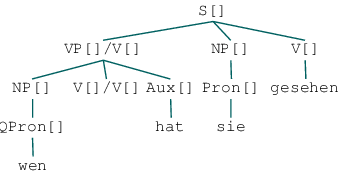

In [380]:
sentence = "wen hat sie gesehen"

gramstring = r"""
% start S

    S -> VP/V NP V

    VP/?x -> NP V/?x Aux

    V/V -> 

    NP -> Pron | QPron

    QPron   -> "wen"
    Pron   -> "sie"
    Aux   -> "hat" 
    V   -> "gesehen" 

"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree = Tree.fromstring(str(tree).replace(", ",","))
    #tree.pretty_print(unicodelines=True)
    display(tree)

### Geben Sie die Regel aus obenstehender Grammatik an, die das folgende implementiert (Zuordnung gemäß Matrikelnummer):



- `Mnr 0-2:` **`SUBJEKT-VP-INVERSION`**


- `Mnr 3-4:` **`GAP-INTRODUCTION`**


- `Mnr 5-7:` **`HERUNTERREICHEN DER GAP-INFORMATIONEN`**


- `Mnr 8-9:` **`GAP-REALISIERUNG`**



In [ ]:
#TO_DO:
gramstring = r"""

"""

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (7):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
gramstring = r"""

"""
</code>
</div>

---

## 8. Syntaxregeln komplexer Sätze


## 8.1 CFG-Regeln für komplexe Sätze

#### Gegeben sei folgender Satz mit transitivem Verb und eine entsprechende Grammatik:



In [3]:
sentence = "es erheitert den Briefträger"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N
    NP  -> Pron

    Det -> "den"
    N   -> "Briefträger"
    Pron   -> "es"
    V   -> "erheitert"
    
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    
    

                S                     
 ┌──────────────┴───┐                  
 │                  VP                
 │       ┌──────────┴───┐              
 NP      │              NP            
 │       │          ┌───┴───────┐      
Pron     V         Det          N     
 │       │          │           │      
 es  erheitert     den     Briefträger



### 8.1 a) Passen Sie den Satz  in der folgenden Zelle an, so dass er einen:

- `Mnr 0-3:` **Subjektsatz**


- `Mnr 4-6:` **Adverbialsatz**


- `Mnr 7-9:` **Relativsatz**

### enthält (Zuordnung gemäß Matrikelnummer).

### Dieser Nebensatz soll dabei folgende VP enthalten:  

 *einen Brief schreiben*



#### (Satzzeichen müssen nicht berücksichtigt werden!)


In [43]:
#TO_DO:
sentence = "es erheitert den Briefträger"

---

[zurück zur Übersicht](#Übersicht)


### 8.1 b) Erweitern Sie die Grammatik um entsprechende lexikalische und syntaktische Regeln für Ihren  Satz aus 8.1a.



- Verwenden Sie nur `SBAR` und `Comp` als neue Nonterminale
- X-Bar-Schema ist nicht notwendig (orientieren Sie sich an den Penn-Treebank-Regeln für komplexe Sätze)

##### Beachten Sie die invertierte Wortstellung im Nebensatz (Verbendstellung).

In [ ]:
#TO_DO:
grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N
    NP  -> Pron

    Det -> "den"
    N   -> "Briefträger"
    Pron   -> "es"
    V   -> "erheitert"

###########ERGAENZTE REGELN:    

""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (8.1a):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sentence = "es erheitert den Briefträger"
</code>
</div>

*Ursprüngliche Angabe (8.1b):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V NP
    NP  -> Det N
    NP  -> Pron

    Det -> "den"
    N   -> "Briefträger"
    Pron   -> "es"
    V   -> "erheitert"

###########ERGAENZTE REGELN:    
    
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    
</code>
</div>

---

## 8.2. Analysieren Sie die Dependenzbeziehungen Ihres Beispielsatzes aus 8.1 im UD-Schema


In [9]:
#TO_DO:
sent_nr = """
1 x 2 dep
2 y 0 ROOT
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

y(ROOT)
   │    
 x(dep)



---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (8.2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sent_nr = """
1 x 2 dep
2 y 0 ROOT
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)  

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})
</code>
</div>

---

## 9. Parsing-Algorithmen und Rekursionstypen

### 9.1 Geben Sie CFG-Regeln an, die bei einem Bottom-Up-Parser wegen Ambiguität zu längerer Laufzeit führen können.


In [ ]:
#TO_DO:
grammar = nltk.CFG.fromstring("""

""")

print(grammar)

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (9.1):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
grammar = nltk.CFG.fromstring("""

""")

print(grammar)
</code>
</div>

--- 

### 9.2 Geben Sie eine CFG-Regel an, die nicht mit einem Recursive-Descent-Parser verarbeitet werden kann.


In [22]:
#TO_DO:

grammar = nltk.CFG.fromstring("""

""")

print(grammar)


Grammar with 1 productions (start state = VP)
    VP -> VP PP


---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (9.2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
grammar = nltk.CFG.fromstring("""

""")

print(grammar)
</code>
</div>

---

## 10. Unifikationsparsing und getypte Merkmalstrukturen





## 10.1 Unifikation und Merkmalsstrukturen

#### Gegeben seien folgende (unifizierende) Merkmalsstrukturen:

In [5]:
f1 = FeatStruct("[CAT=[+FEAT]]")
f2 = FeatStruct("[]")
print(f1.unify(f2))

[ CAT = [ FEAT = True ] ]



### Geben Sie eine Merkmalsstruktur `f2` an, die ***nicht*** mit `f1`unifiziert (print-Ausgabe: None).

In [23]:
#TO_DO:

f1 = FeatStruct("[CAT=[+FEAT]]")
f2 = FeatStruct("[]")
print(f1.unify(f2))

None


---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (10.1):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
f1 = FeatStruct("[CAT=[+FEAT]]")
f2 = FeatStruct("[]")
print(f1.unify(f2))
</code>
</div>

---


## 10.2 Unifikation mit Typen

#### Gegeben sei folgende Typhierarchie:

$$\bot \sqsubseteq \text{Genitiv}$$
$$\bot \sqsubseteq \text{nicht-Genitiv}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Nominativ-Akkusativ}$$
$$\text{nicht-Genitiv} \sqsubseteq \text{Dativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Nominativ}$$
$$\text{Nominativ-Akkusativ} \sqsubseteq \text{Akkusativ}$$

####  Sie wird (mit abgekürzten Typnamen) durch das `*CASE*`-Feature implementiert:

In [24]:
#RUN (Führen Sie zunächst diese Code-Zelle aus):
type_hierarchy = {
    "nichtGen": ["NomAkk", "Dat"],
    "NomAkk": ["Nom", "Akk"],
    "Dat": [],
    "Akk": [],
    "Gen": [],
    "Nom": []
}
CASE = HierarchicalFeature("CASE", type_hierarchy)
reader = FeatStructReader(features=(CASE,))

### Führen Sie obenstehende Codezelle aus, um die Typhierarchie zu laden.

### Geben Sie eine Merkmalstruktur `f3` an, sodass gilt:

`f1` subsumiert `f3`.

In [94]:
#TO_DO:
f1 = reader.fromstring("[*CASE*=NomAkk]")
f3 = reader.fromstring("[]")
f1.subsumes(f3)

False

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (10.2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
f1 = reader.fromstring("[*CASE*=NomAkk]")
f3 = reader.fromstring("[]")
f1.subsumes(f3)
</code>
</div>

---

## 11. Statistisches Parsing


## 11.1 PCFG: Gewichte und Ableitungswahrscheinlichkeit



#### Gegeben sei folgende Mini-Treebank mit PP-Attachment-Sätzen:


In [50]:
treestrings = [
"(S (NP Er) (VP (VP (V legt) (NP die Karten)) (PP auf den Tisch)))",
"(S (NP Er) (VP (V legt) (NP (NP die Karten) (PP auf dem Tisch))))",
"(S (NP Wir) (VP (VP (V trafen) (NP das Tier)) (PP im Schlafanzug)))",
"(S (NP Wir) (VP (V trafen) (NP (NP das Tier) (PP im Schlafanzug))))",
"(S (NP Sie) (VP (V kennt) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Sie) (VP (V mögen) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Wir) (VP (V sehen) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Du) (VP (V glaubst) (PP an den Weihnachtsmann)))",
]

trees = []
for treestring in treestrings:
    trees.append(Tree.fromstring(treestring))
    
for tree in trees:
    tree.pretty_print(unicodelines=True)

     S                               
 ┌───┴─────────────┐                  
 │                 VP                
 │        ┌────────┴─────────┐        
 │        VP                 │       
 │   ┌────┴───┐              │        
 NP  V        NP             PP      
 │   │    ┌───┴────┐     ┌───┼────┐   
 Er legt die     Karten auf den Tisch

     S                               
 ┌───┴─────────────┐                  
 │                 VP                
 │   ┌─────────────┴─────┐            
 │   │                   NP          
 │   │        ┌──────────┴───┐        
 NP  V        NP             PP      
 │   │    ┌───┴────┐     ┌───┼────┐   
 Er legt die     Karten auf dem Tisch

            S                              
 ┌──────────┴───────┐                       
 │                  VP                     
 │          ┌───────┴────────┐              
 │          VP               │             
 │    ┌─────┴───┐            │              
 NP   V         NP           PP        

### Passen Sie diese Mini-Treebank durch Auskommentieren einer minimalen Anzahl an Sätzen so an, dass die daraus induzierte Grammatik das VP-Attachment bevorzugt.


In [25]:
#TO_DO:

treestrings = [
"(S (NP Er) (VP (VP (V legt) (NP die Karten)) (PP auf den Tisch)))",
"(S (NP Er) (VP (V legt) (NP (NP die Karten) (PP auf dem Tisch))))",
"(S (NP Wir) (VP (VP (V trafen) (NP das Tier)) (PP im Schlafanzug)))",
"(S (NP Wir) (VP (V trafen) (NP (NP das Tier) (PP im Schlafanzug))))",
"(S (NP Sie) (VP (V kennt) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Sie) (VP (V mögen) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Wir) (VP (V sehen) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Du) (VP (V glaubst) (PP an den Weihnachtsmann)))",
]


trees = []
for treestring in treestrings:
    trees.append(Tree.fromstring(treestring))

#grammar induction:
productions = []
S = nltk.Nonterminal('S')

for tree in trees:
    productions += tree.productions()

grammar = nltk.induce_pcfg(S, productions)
for production in grammar.productions():
    print(production)    

#parse trees with grammar:
parser = nltk.ViterbiParser(grammar)

for tree in trees:
    for parse in parser.parse(tree.leaves()): 
        print(parse)
        parse.pretty_print(unicodelines=True) 


S -> NP VP [1.0]
NP -> 'Er' [0.142857]
VP -> VP PP [0.25]
VP -> V NP [0.625]
V -> 'legt' [0.333333]
NP -> 'die' 'Karten' [0.142857]
PP -> 'auf' 'den' 'Tisch' [0.166667]
NP -> NP PP [0.214286]
PP -> 'auf' 'dem' 'Tisch' [0.166667]
NP -> 'Wir' [0.142857]
V -> 'trafen' [0.166667]
NP -> 'das' 'Tier' [0.214286]
PP -> 'im' 'Schlafanzug' [0.166667]
NP -> 'Sie' [0.0714286]
V -> 'mögen' [0.166667]
PP -> 'mit' 'dem' 'Fernglas' [0.333333]
V -> 'sehen' [0.166667]
NP -> 'Du' [0.0714286]
VP -> V PP [0.125]
V -> 'glaubst' [0.166667]
PP -> 'an' 'den' 'Weihnachtsmann' [0.166667]
(S
  (NP Er)
  (VP (VP (V legt) (NP die Karten)) (PP auf den Tisch))) (p=0.000177154)
     S                               
 ┌───┴─────────────┐                  
 │                 VP                
 │        ┌────────┴─────────┐        
 │        VP                 │       
 │   ┌────┴───┐              │        
 NP  V        NP             PP      
 │   │    ┌───┴────┐     ┌───┼────┐   
 Er legt die     Karten auf den Tisch


---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (11.1):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
treestrings = [
"(S (NP Er) (VP (VP (V legt) (NP die Karten)) (PP auf den Tisch)))",
"(S (NP Er) (VP (V legt) (NP (NP die Karten) (PP auf dem Tisch))))",
"(S (NP Wir) (VP (VP (V trafen) (NP das Tier)) (PP im Schlafanzug)))",
"(S (NP Wir) (VP (V trafen) (NP (NP das Tier) (PP im Schlafanzug))))",
"(S (NP Sie) (VP (V kennt) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Sie) (VP (V mögen) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Wir) (VP (V sehen) (NP (NP das Tier) (PP mit dem Fernglas))))",
"(S (NP Du) (VP (V glaubst) (PP an den Weihnachtsmann)))",
]


trees = []
for treestring in treestrings:
    trees.append(Tree.fromstring(treestring))
    
    
#grammar induction:    
productions = []
S = nltk.Nonterminal('S')

for tree in trees:
    productions += tree.productions()

grammar = nltk.induce_pcfg(S, productions)
for production in grammar.productions():
    print(production)    
    
#parse trees with grammar:    
parser = nltk.ViterbiParser(grammar)
     
for tree in trees:
    for parse in parser.parse(tree.leaves()): 
        print(parse)
        parse.pretty_print(unicodelines=True) 
</code>
</div>

---

## 11.2 Übergangsbasierter Shift-Reduce-Dependency-Parser

#### Gegeben sei folgender Dependenzgraph:

In [13]:
sent_nr = """
1 a 2 LEFTARC-?
2 b 0 ROOT
3 c 4 LEFTARC-?
4 d 2 RIGHTARC-?
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

### Geben Sie eine deutschen oder englischen Satz an, der diese Dependenzstrukturanalyse erfüllt; geben Sie außerdem die Reihenfolge der Durchführung der REDUCE-Übergänge mit einem Shift-Reduce-Dependency-Parser an. 

#### (Ersetzen Sie ausschließlich die Buchstaben `a,b,c,d` mit entsprechenden Wörtern sowie das Fragezeichen mit der Angaben der Nummer der Durchführung des REDUCE-Schritts.)

In [ ]:
#TO_DO:

sent_nr = """
1 a 2 LEFTARC-?
2 b 0 ROOT
3 c 4 LEFTARC-?
4 d 2 RIGHTARC-?
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (11.2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sent_nr = """
1 a 2 LEFTARC-?
2 b 0 ROOT
3 c 4 LEFTARC-?
4 d 2 RIGHTARC-?
"""

sent = transform_nr_conll(sent_nr)
dg = DependencyGraph(sent)

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})
</code>
</div>

---

## 12. Datengestützte Syntaxanalyse




## 12.1 Lexikalisierte CFG (mit Merkmalen)

#### Gegeben sei folgende FCFG:

In [9]:
sentence = "er steigt auf den Berg"

gramstring = r"""
% start S
    S[]   -> NP[] VP[]
    VP[]  -> V[] PP[]
    NP[]  -> Det[] N[]
    NP[]  -> N[]
    PP[]  -> P[] NP[]

    Det[] -> "den"
    N[]   -> "er"    
    N[]   -> "Berg"
    P[]   -> "auf"
    V[]   -> "steigt"    
"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    print(tree)    
    tree = Tree.fromstring(str(tree).replace(", ",","))
    tree.pretty_print(unicodelines=True)
    #display(tree)

(S[]
  (NP[] (N[] er))
  (VP[] (V[] steigt) (PP[] (P[] auf) (NP[] (Det[] den) (N[] Berg)))))
            S[]                     
 ┌───────────┴───┐                   
 │              VP[]                
 │     ┌─────────┴─────┐             
 │     │              PP[]          
 │     │     ┌─────────┴────┐        
NP[]   │     │             NP[]     
 │     │     │         ┌────┴────┐   
N[]   V[]   P[]      Det[]      N[] 
 │     │     │         │         │   
 er  steigt auf       den       Berg



### Führen Sie über ein HEAD-Merkmal in der FCFG eine vollständige Kopfannotation durch.

#### (Sie können sowohl die UD als auch die TIGER-Dependenzregeln verwenden.)


In [26]:
#TO_DO:

sentence = "er steigt auf den Berg"

gramstring = r"""
% start S
    S[]   -> NP[] VP[]
    VP[]  -> V[] PP[]
    NP[]  -> Det[] N[]
    NP[]  -> N[]
    PP[]  -> P[] NP[]

    Det[] -> "den"
    N[]   -> "er"    
    N[]   -> "Berg"
    P[]   -> "auf"
    V[]   -> "steigt"    

"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    print(tree)
    tree = Tree.fromstring(str(tree).replace(", ",","))
    tree.pretty_print(unicodelines=True)
    #display(tree)

ValueError: Unable to parse line 9: Det[DET] -> "den"
Error parsing feature structure
    Det[DET] -> "den"
           ^ Expected equals sign

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (12.1):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sentence = "er steigt auf den Berg"

gramstring = r"""
% start S
    S[]   -> NP[] VP[]
    VP[]  -> V[] PP[]
    NP[]  -> Det[] N[]
    NP[]  -> N[]
    PP[]  -> P[] NP[]

    Det[] -> "den"
    N[]   -> "er"    
    N[]   -> "Berg"
    P[]   -> "auf"
    V[]   -> "steigt"    
"""

grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
parser = nltk.parse.FeatureChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    print(tree)    
    tree = Tree.fromstring(str(tree).replace(", ",","))
    tree.pretty_print(unicodelines=True)
    #display(tree)
</code>
</div>


---


## 12.2 Parent Annotation (mit Symbolerweiterung)

#### Gegeben sei folgende CFG für einen Satz mit PP-Komplement:


In [8]:
sentence = "er steigt auf den Berg"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V PP
    NP  -> Det N
    NP  -> N
    PP  -> P NP

    Det -> "den"
    N   -> "er"    
    N   -> "Berg"
    P   -> "auf"
    V   -> "steigt"        
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    

            S                  
 ┌──────────┴───┐               
 │              VP             
 │    ┌─────────┴───┐           
 │    │             PP         
 │    │     ┌───────┴───┐       
 NP   │     │           NP     
 │    │     │       ┌───┴───┐   
 N    V     P      Det      N  
 │    │     │       │       │   
 er steigt auf     den     Berg



### Führen Sie über Symbolerweiterung (mit `^` als Trennerzeichen) in der CFG eine vollständige *Parent Annotation* durch, wie Sie durch die Regelanwendungen im Syntaxbaum der Angabe impliziert ist.

In [7]:
#TO_DO:

sentence = "er steigt auf den Berg"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V PP
    NP  -> Det N
    NP  -> N
    PP  -> P NP

    Det -> "den"
    N   -> "er"    
    N   -> "Berg"
    P   -> "auf"
    V   -> "steigt"    

###########ERGAENZTE REGELN:    

""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (12.2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
sentence = "er steigt auf den Berg"

grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    VP  -> V PP
    NP  -> Det N
    NP  -> N
    PP  -> P NP

    Det -> "den"
    N   -> "er"    
    N   -> "Berg"
    P   -> "auf"
    V   -> "steigt"    

###########ERGAENZTE REGELN:    
    
""")

parser = nltk.ChartParser(grammar,trace=0)

for tree in parser.parse(sentence.split()):
    tree.pretty_print(unicodelines=True)    
</code>
</div>

---

## 13. Chunk-Analysen und Komplexität



## 13.1 Geben Sie einen folgende *IOB-Tag-Sequenz* einer NP-Chunk-Analyse erfüllenden deutschen Satz an, indem Sie die TODOs mit entsprechenden Strings ersetzen (nehmen Sie keine weiteren Änderungen vor).

#### (Beachten Sie auch die gegebenen Satzzeichen bzgl. möglicher Satztypen und entsprechender Worstellung.)


In [ ]:
#TO_DO:
iob_list = [
("O", TODO), 
("B-NP", TODO),
("B-NP", TODO),
("I-NP", TODO),
("I-NP", TODO),    
("B-NP", TODO),
("I-NP", TODO),
("O", "?")
]

print(iob_list)

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (13.1):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
iob_list = [
("O", TODO), 
("B-NP", TODO),
("B-NP", TODO),
("I-NP", TODO),
("I-NP", TODO),    
("B-NP", TODO),
("I-NP", TODO),
("O", "?")
]

print(iob_list)
</code>
</div>

---
 
 
## 13.2 Verarbeitung syntaktischer Konstruktionen

#### Gegeben sei folgende Liste von Sätzen und Satzfragmenten:


In [28]:
constructions = [
"Max streicht das Haus",    
"Max ist der Katze begegnet",
"der Mann, der die Katze, die auf dem Baum geklettert war, gerettet hat, wird ausgezeichnet",
"der Mann wird ausgezeichnet, der die Katze gerettet hat, die auf dem Baum geklettert war", 
"dass wir ihm das Haus anstreichen helfen" ,
"den Tanz lehren wir ihn zu tanzen",
"dass wir ihn den Tanz zu tanzen lehren"    
]

for (i, item) in enumerate(constructions):
    print(i, item)    

0 Max streicht das Haus
1 Max ist der Katze begegnet
2 der Mann, der die Katze, die auf dem Baum geklettert war, gerettet hat, wird ausgezeichnet
3 der Mann wird ausgezeichnet, der die Katze gerettet hat, die auf dem Baum geklettert war
4 dass wir ihm das Haus anstreichen helfen
5 den Tanz lehren wir ihn zu tanzen
6 dass wir ihn den Tanz zu tanzen lehren


### Wählen Sie aus dieser Liste (über den Listenindex) ein Element aus, das folgende syntaktische Struktur enthält (Zuordnung gemäß Matrikelnummer):



- `Mnr 0-5:` ***center embedding*-Struktur** 
    - *(d.h. die Verarbeitung benötigt mindestens eine CFG)*


- `Mnr 6-9:` ***long distance dependency***
    - *(d.h. die Verarbeitung ist nur mit einem nicht-projektiven Dependency-Parser möglich)*



In [31]:
#TO_DO:
constructions[TODO]

'den Tanz lehren wir ihn zu tanzen'

---

[zurück zur Übersicht](#Übersicht)


*Ursprüngliche Angabe (13.2):*

<div style="border: 2px solid gray;font-size:80%; background-color: #F0F0F0; line-height: 1.5;">
<code>
constructions[TODO]
</code>
</div>